In [1]:
import os
from matplotlib.image import imread
import seaborn as sns
sns.set_theme(palette=sns.color_palette('Set2'))
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np

In [2]:
train_folder = 'train_rotated_clustered_edges'
test_folder = 'test_rotated_clustered_edges'

### data analysis

In [3]:
print('number of files in train categories:')
for class_name in ['paper','rock','scissors']:
    print(f'{class_name}: ' + str(len(os.listdir(f'{train_folder}/{class_name}'))))

number of files in train categories:
paper: 612
rock: 626
scissors: 650


In [4]:
print('number of files in test categories:')
for class_name in ['paper','rock','scissors']:
    print(f'{class_name}: ' + str(len(os.listdir(f'{test_folder}/{class_name}'))))

number of files in test categories:
paper: 100
rock: 100
scissors: 100


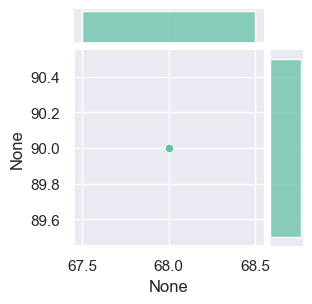

In [5]:
dim1 = []
dim2 = []
for dir1 in [train_folder,test_folder]:
    for dir2 in os.listdir(dir1):
        for img_name in os.listdir(dir1 + '\\' + dir2): 
            img = imread(dir1 + '\\' + dir2 + '\\' + img_name)
            d1,d2 = img.shape
            dim1.append(d1)
            dim2.append(d2)
sns.jointplot(x=dim1,y=dim2,height=3)

### image generator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.src.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more infor

In [8]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
                               rescale=1./255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=False,
                               fill_mode='nearest'
                              )

In [9]:
rock_img = imread(f'{train_folder}\\rock\\' + os.listdir(f'{train_folder}\\rock')[0])

(-0.5, 89.5, 67.5, -0.5)

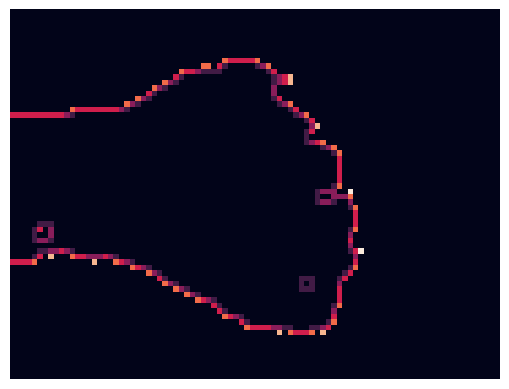

In [10]:
plt.imshow(rock_img)
plt.axis('off')

In [11]:
rock_img = rock_img.reshape(68,90,1)

(-0.5, 89.5, 67.5, -0.5)

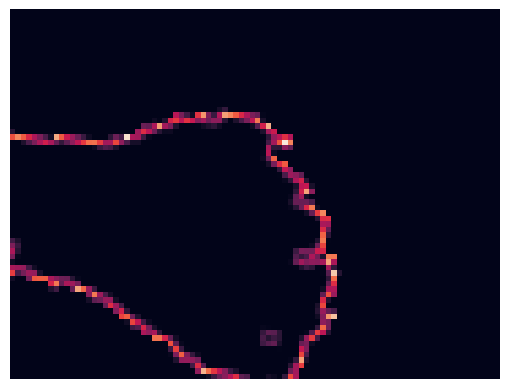

In [12]:
plt.imshow(image_gen.random_transform(rock_img))
plt.axis('off')

In [13]:
image_gen.flow_from_directory(train_folder)

Found 1888 images belonging to 3 classes.


In [14]:
image_gen.flow_from_directory(test_folder)

Found 300 images belonging to 3 classes.


### cnn model

In [15]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

In [16]:
rock_img.shape

(68, 90, 1)

In [17]:
image_shape = (rock_img.shape[0], rock_img.shape[1], 1)

In [18]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = models.Sequential()

model.add(layers.Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Flatten())


model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 66, 88, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 33, 44, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 42, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 21, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 19, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 9, 64)          0

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

### training the model

In [21]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module keras.src.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest', keep_aspect_ratio=False) method of keras.src.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    Args:
      directory: string, path to the target directory. It should contain
        one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images
        inside each of the subdirectories directory tree will be included
        in the generator. See [this script](
        https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
        for more details.
      target_size: Tuple of integers `(height, width)`. The dimensions to
        which all images found will be

In [22]:
batch_size = 16

In [23]:
train_image_gen = image_gen.flow_from_directory(train_folder,
                                                target_size=image_shape[:2],
                                                color_mode='grayscale',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 1888 images belonging to 3 classes.


In [24]:
test_image_gen = image_gen.flow_from_directory(test_folder,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)

Found 300 images belonging to 3 classes.


(-0.5, 89.5, 67.5, -0.5)

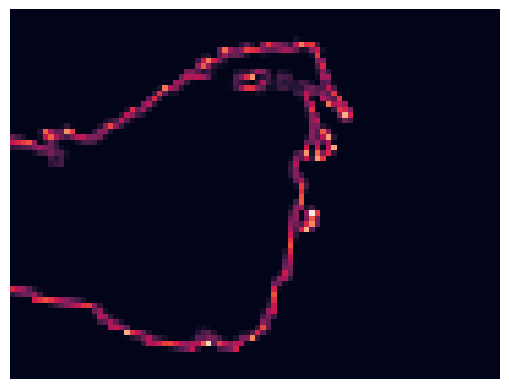

In [25]:
plt.imshow(train_image_gen.next()[0][0])
plt.axis('off')

(-0.5, 89.5, 67.5, -0.5)

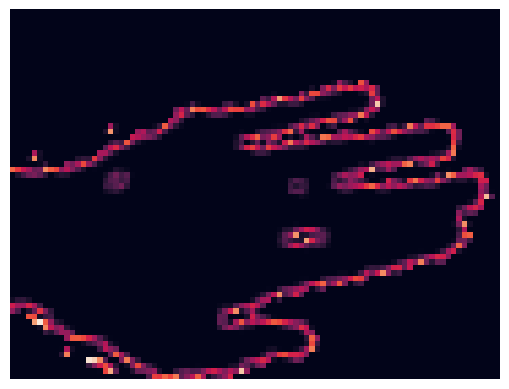

In [26]:
plt.imshow(test_image_gen.next()[0][0])
plt.axis('off')

In [27]:
train_image_gen.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [28]:
start = time.time()

results = model.fit(train_image_gen,
                    epochs=20,
                    validation_data=test_image_gen,
                    callbacks=[early_stop],
                    )

stop = time.time()
print('\n',(stop-start)//60,'min.')

Epoch 1/20


118/118 [==============================] - 7s 52ms/step - loss: 0.6607 - accuracy: 0.7209 - val_loss: 0.3526 - val_accuracy: 0.8633
Epoch 2/20
118/118 [==============================] - 6s 49ms/step - loss: 0.3478 - accuracy: 0.8761 - val_loss: 0.2377 - val_accuracy: 0.9233
Epoch 3/20
118/118 [==============================] - 6s 51ms/step - loss: 0.2319 - accuracy: 0.9174 - val_loss: 0.1918 - val_accuracy: 0.9300
Epoch 4/20
118/118 [==============================] - 7s 55ms/step - loss: 0.2167 - accuracy: 0.9274 - val_loss: 0.2304 - val_accuracy: 0.9367
Epoch 5/20
118/118 [==============================] - 7s 62ms/step - loss: 0.1748 - accuracy: 0.9396 - val_loss: 0.1510 - val_accuracy: 0.9333
Epoch 6/20
118/118 [==============================] - 8s 65ms/step - loss: 0.1601 - accuracy: 0.9391 - val_loss: 0.2059 - val_accuracy: 0.9267
Epoch 7/20
118/118 [==============================] - 8s 65ms/step - loss: 0.1552 - accuracy: 0.9492 - val_loss: 0.1236 - val_accuracy: 0.95

In [29]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M")
model.save('models\\' + timestamp + '.keras')

### model evaluation

In [30]:
losses = pd.DataFrame(model.history.history)

<Axes: >

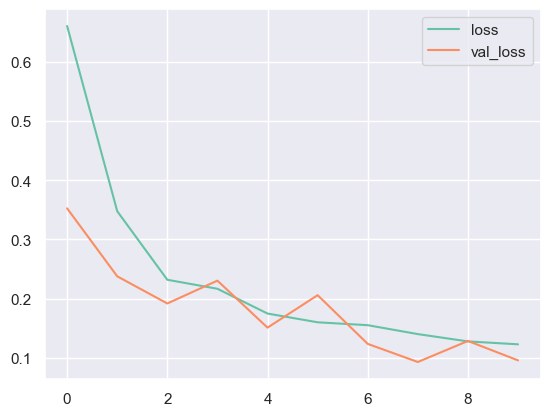

In [31]:
losses[['loss','val_loss']].plot()

<Axes: >

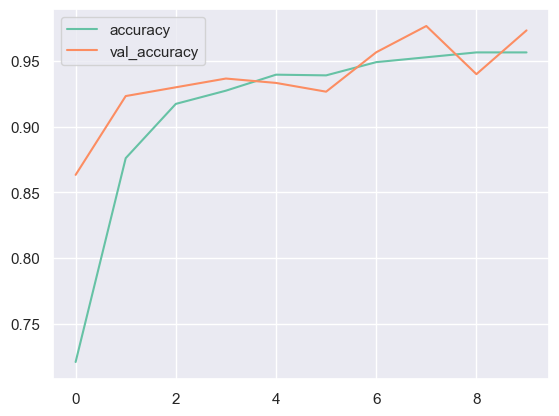

In [32]:
losses[['accuracy','val_accuracy']].plot()

In [33]:
model.metrics_names

['loss', 'accuracy']

In [34]:
model.evaluate(test_image_gen)

19/19 [==============================] - 1s 25ms/step - loss: 0.1118 - accuracy: 0.9700


[0.11178755760192871, 0.9700000286102295]

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [36]:
predictions = np.argmax(model.predict(test_image_gen), axis=-1)

19/19 [==============================] - 1s 24ms/step


In [37]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       100
           1       0.99      0.99      0.99       100
           2       0.98      0.94      0.96       100

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [38]:
cm = confusion_matrix(test_image_gen.classes,predictions)
cm

array([[98,  1,  1],
       [ 0, 99,  1],
       [ 6,  0, 94]], dtype=int64)

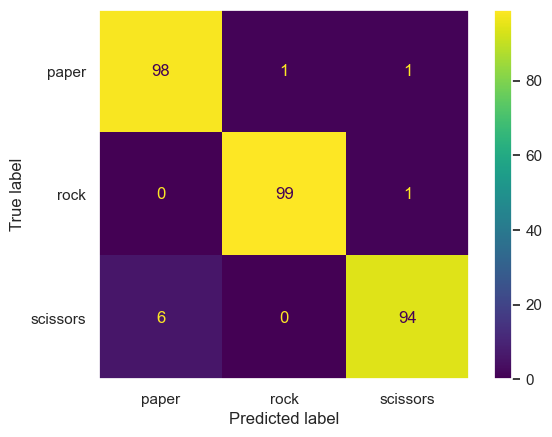

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_image_gen.class_indices)
disp.plot()
plt.grid(False)
plt.show()